Представьте, что вы работаете в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед вами стоит задача проанализировать ВВП африканской страны Гана. Для этого вам предоставили показатели ВВП Ганы за 62 года. Вам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.

In [1]:
import pandas as pd, numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics

import datetime, time

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa import seasonal
from statsmodels.tsa import stattools
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima import model

from arch import univariate
import pmdarima as pm

### **PART ONE**

#### **PART 1.1**

Прочитайте исходный файл с данными.

In [2]:
ghana_data = pd.read_csv('data/ghana_gdp.csv',
                         index_col=['year'],
                         parse_dates=['year'])

ghana_data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

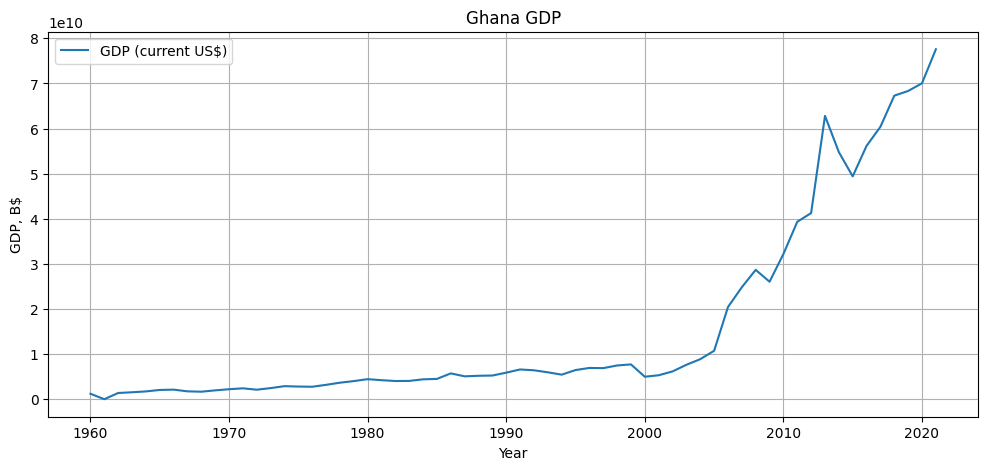

In [3]:
_, ax_line = plt.subplots(figsize=(12, 5))

ax_line = sns.lineplot(data=ghana_data,
                       ax=ax_line)

ax_line.set(
    title='Ghana GDP',
    xlabel='Year',
    ylabel='GDP, ' + 'B$'
)
ax_line.grid();

**Вывод**: \
Рост с 2000 года и далее, значительный подъем и спад в середине 2010-х годов (стоит рассмотреть подробнее), и дальнейший продолжающийся рост.

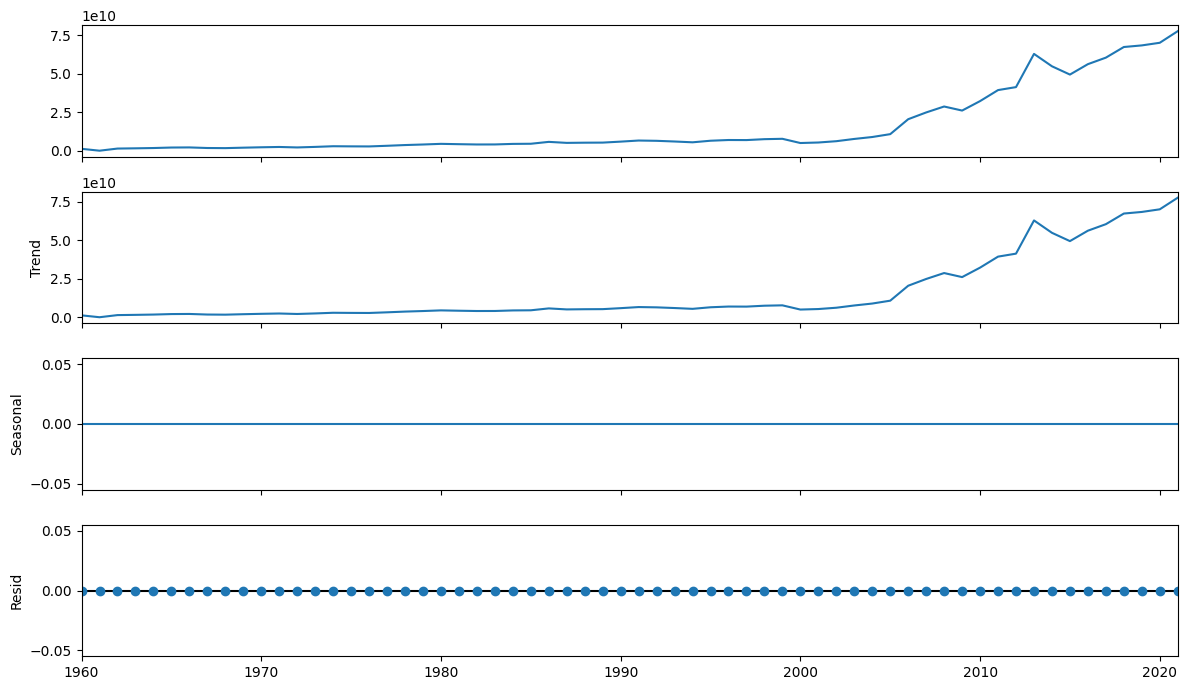

In [4]:
plt.rcParams['figure.figsize'] = 12, 7

#decompose the time series
decomposition = seasonal.seasonal_decompose(ghana_data)
decomposition.plot();

**Вывод**: \
Восходящая тенденция, но мало что указывает на сезонность; нет выбросов, остатки расположены около 0.

Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

In [5]:
#split the sample
train_df = ghana_data[:-3]
test_df = ghana_data[-3:]

print(train_df.shape, test_df.shape)

(59, 1) (3, 1)


#### **PART 1.2**

Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

Пример: train_df.spx.rolling(window=2).mean().

Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

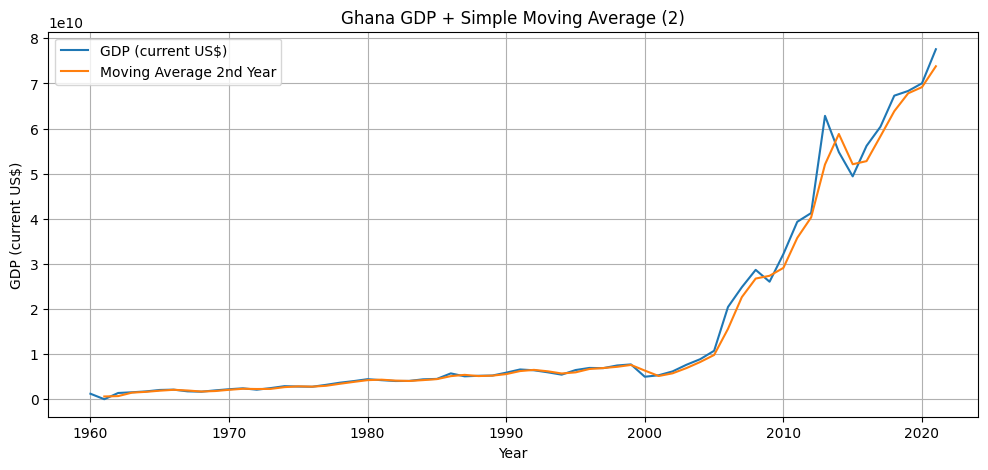

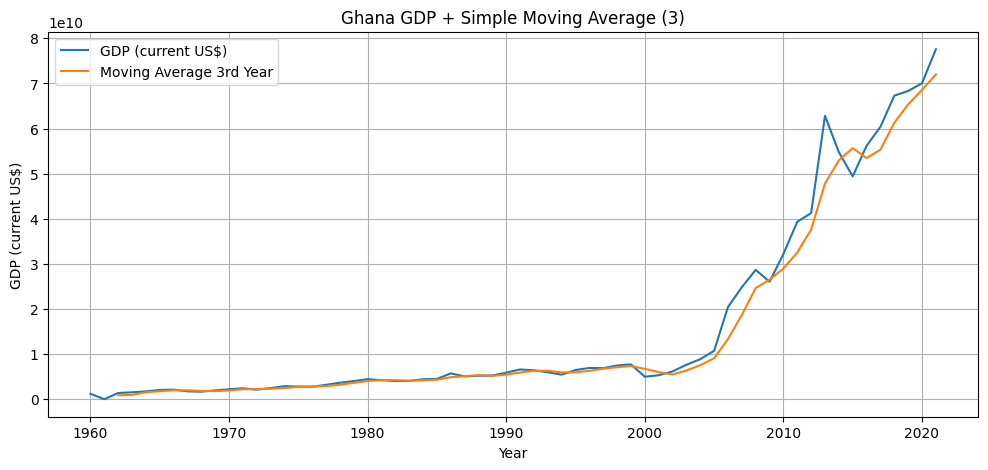

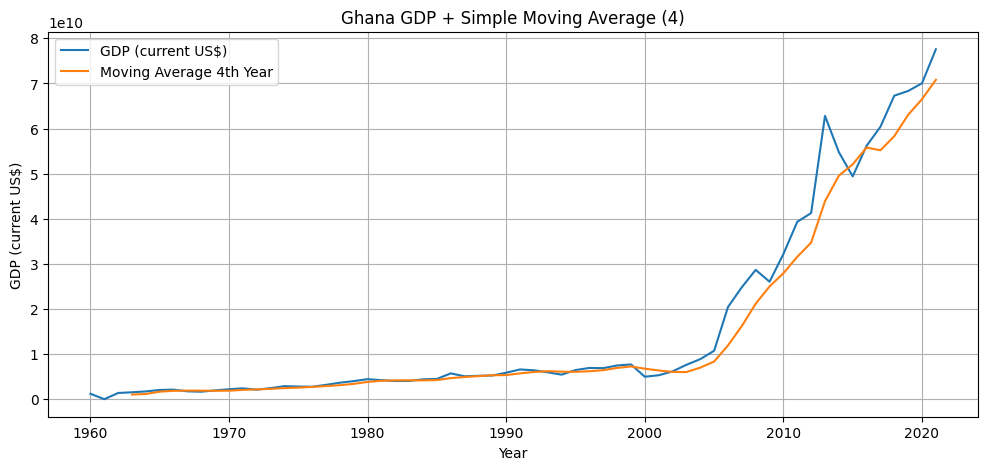

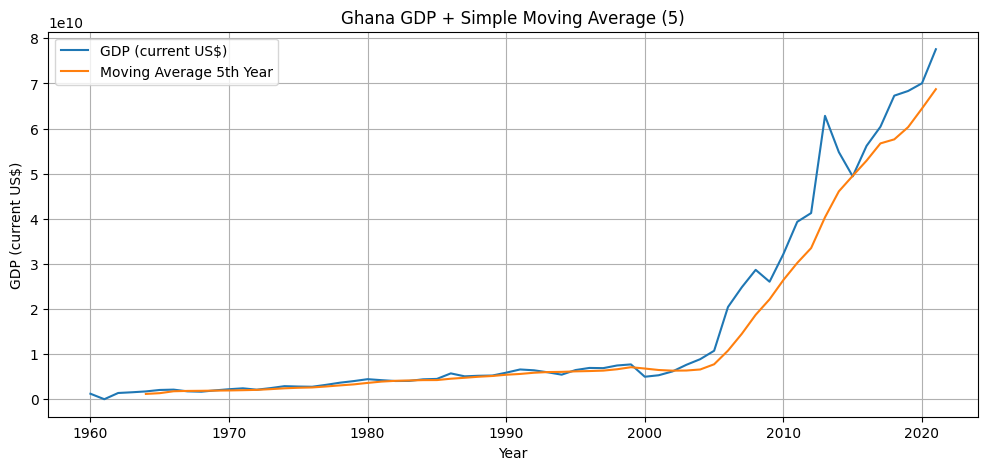

In [6]:
for i in range(2, 6):
    fig, ax_line = plt.subplots(figsize=(12, 5))

    ax_line = sns.lineplot(x=ghana_data.index,
                           y=ghana_data[ghana_data.columns[0]],
                           label=ghana_data.columns[0])

    moving_average = ghana_data.rolling(i).mean()

    #update the label(s)
    if i == 2:
      ax_line = sns.lineplot(x=moving_average.index,
                             y=moving_average[ghana_data.columns[0]],
                             label='Moving Average '  + str(i) + 'nd Year')
    elif i == 3:
      ax_line = sns.lineplot(x=moving_average.index,
                             y=moving_average[ghana_data.columns[0]],
                             label='Moving Average '  + str(i) + 'rd Year')
    elif i >= 4:
      ax_line = sns.lineplot(x=moving_average.index,
                             y=moving_average[ghana_data.columns[0]],
                             label='Moving Average '  + str(i) + 'th Year')

    ax_line.grid()
    ax_line.set_xlabel('Year')
    _ = plt.title('Ghana GDP + Simple Moving Average (' + str(i) + ')')

**Вывод**: \
Небольшой рост с 1960-х по 2000-е годы и устойчивый рост с начала 2000-х годов.

#### **PART 1.3**

С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.

*Примечание*. Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.

Параметры p и q выберите по коррелограммам ACF и PACF.

Примечание. Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.

Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.
Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).

**Augmented Dickey–Fuller Test**

In [7]:
def execute_augmented_dickey_fuller_test(table: pd.DataFrame,
                                         crit_value: int):

  #execute the test
  stationary_test = stattools.adfuller(table)

  #unpack the results per critical value set
  print(f'ADF: {round(stationary_test[0], 5)}')
  print(f'p_value: {round(stationary_test[1], 5)}')

  if crit_value == 1:
    print(f'critical value, 1%: {round(stationary_test[4]["1%"], 5)}')

  elif crit_value == 5:
    print(f'critical value, 5%: {round(stationary_test[4]["5%"], 5)}')

  elif crit_value == 10:
    print(f'critical value, 10%: {round(stationary_test[4]["10%"], 5)}')


  def check_for_stationarity(test_result: tuple,
                             crit_value: int):

    if crit_value == 1:
      if test_result[0] > test_result[4]["1%"]:
        return f'at {crit_value}% threshold: {round(test_result[0], 5)} > {round(test_result[4]["1%"], 5)} thus series is not stationary as roots exist'
      else:
        return f'at {crit_value}% threshold - series is stationary as roots do not exist'

    elif crit_value == 5:
      if test_result[0] > test_result[4]["5%"]:
        return f'at {crit_value}% threshold: {round(test_result[0], 5)} > {round(test_result[4]["5%"], 5)} thus series is not stationary as roots exist'
      else:
        return f'at {crit_value}% threshold - series is stationary as roots do not exist'

    elif crit_value == 10:
      if test_result[0] > test_result[4]["10%"]:
        return f'at {crit_value}% threshold: {round(test_result[0], 5)} > {round(test_result[4]["10%"], 5)} thus series is not stationary as roots exist'
      else:
        return f'at {crit_value}% threshold - series is stationary as roots do not exist'

  return check_for_stationarity(stationary_test, crit_value)

##### check for stationarity

In [8]:
print(execute_augmented_dickey_fuller_test(train_df, 1))
print()
print(execute_augmented_dickey_fuller_test(train_df, 5))
print()
print(execute_augmented_dickey_fuller_test(train_df, 10))

ADF: 0.65291
p_value: 0.98885
critical value, 1%: -3.57459
at 1% threshold: 0.65291 > -3.57459 thus series is not stationary as roots exist

ADF: 0.65291
p_value: 0.98885
critical value, 5%: -2.92395
at 5% threshold: 0.65291 > -2.92395 thus series is not stationary as roots exist

ADF: 0.65291
p_value: 0.98885
critical value, 10%: -2.60004
at 10% threshold: 0.65291 > -2.60004 thus series is not stationary as roots exist


Значения по 1%, 5%, и 10% выше критических, поэтому ряд не является стационарным.

##### check for stationarity of the 1st order

In [9]:
print(execute_augmented_dickey_fuller_test(train_df.diff().dropna(), 1))
print()
print(execute_augmented_dickey_fuller_test(train_df.diff().dropna(), 5))
print()
print(execute_augmented_dickey_fuller_test(train_df.diff().dropna(), 10))

ADF: -1.67025
p_value: 0.4465
critical value, 1%: -3.56849
at 1% threshold: -1.67025 > -3.56849 thus series is not stationary as roots exist

ADF: -1.67025
p_value: 0.4465
critical value, 5%: -2.92136
at 5% threshold: -1.67025 > -2.92136 thus series is not stationary as roots exist

ADF: -1.67025
p_value: 0.4465
critical value, 10%: -2.59866
at 10% threshold: -1.67025 > -2.59866 thus series is not stationary as roots exist


Значения по 1%, 5%, и 10% выше критических, поэтому ряд не является стационарным.

##### check for stationarity of the 2nd order

In [10]:
print(execute_augmented_dickey_fuller_test(train_df.diff(2).dropna(), 1))
print()
print(execute_augmented_dickey_fuller_test(train_df.diff(2).dropna(), 5))
print()
print(execute_augmented_dickey_fuller_test(train_df.diff(2).dropna(), 10))

ADF: -3.58367
p_value: 0.00608
critical value, 1%: -3.58483
at 1% threshold: -3.58367 > -3.58483 thus series is not stationary as roots exist

ADF: -3.58367
p_value: 0.00608
critical value, 5%: -2.9283
at 5% threshold - series is stationary as roots do not exist

ADF: -3.58367
p_value: 0.00608
critical value, 10%: -2.60234
at 10% threshold - series is stationary as roots do not exist


Значения только по 1% выше критических, и незначимо, поэтому ряд можно считать стационарным.

##### Параметры p и q выберите по коррелограммам ACF и PACF.

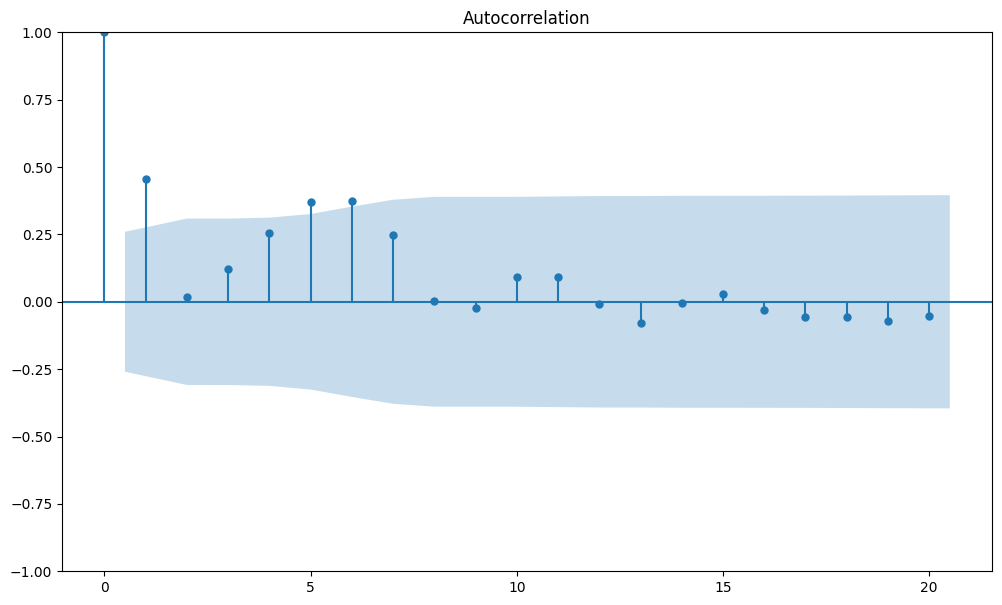

In [11]:
tsaplots.plot_acf(train_df.diff(2).dropna(),
                  lags=20);

Сильная корреляция при lag 1 (и 5, 6).

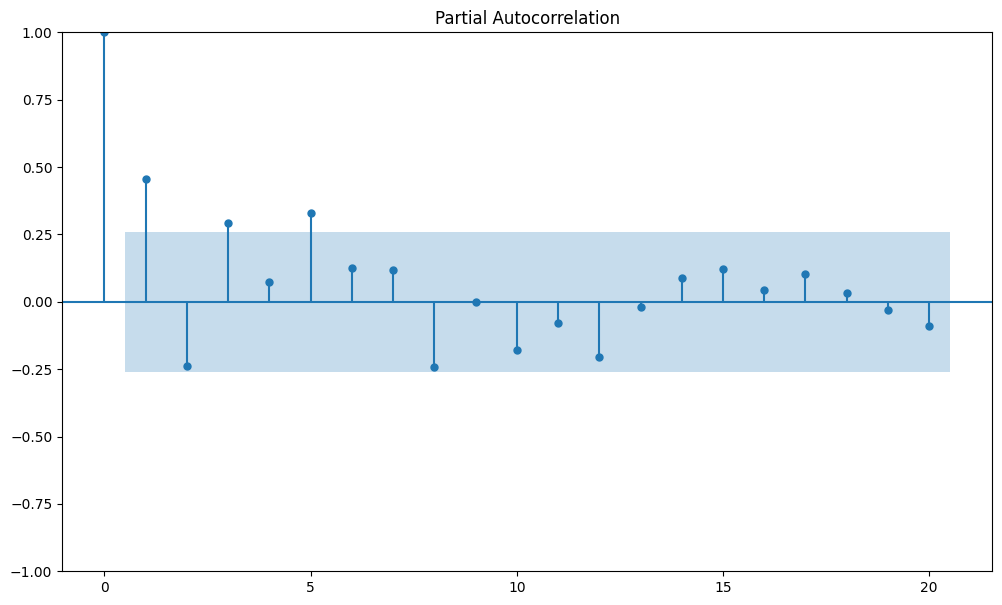

In [12]:
tsaplots.plot_pacf(train_df.diff(2).dropna(),
                   lags=20)
plt.show()

Сильная корреляция при lag 1 (и 3, 5).

In [13]:
arima_model = model.ARIMA(train_df,
                          order=(1, 2, 1))

fit_arima_model = arima_model.fit()

fit_arima_model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.208
Date:                Tue, 10 Jun 2025   AIC                           2684.416
Time:                        06:11:11   BIC                           2690.545
Sample:                    01-01-1960   HQIC                          2686.798
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1775      0.082     -2.159      0.031      -0.339      -0.016
ma.L1         -0.8688      0.046    -19.069      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22    9.2e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               276.42
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             325.65   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.28e+56. Standard errors may be unstable.
"""

Протестировать от 1 до 5.

In [14]:
#search for better hyperparameters
auto_arima_model = pm.arima.auto_arima(
    train_df,
    start_p=1,
    d=2,
    start_q=1,
    test='adf',
    max_p=5,
    max_d=5,
    max_q=5,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.339, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.886, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.594, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.662, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.00 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.054, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.896, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.02 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.926, Time=0.01 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.782, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2693.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Tue, 10 Jun 2025   AIC                           2680.765
Time:                        06:11:11   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.09e+55. Standard errors may be unstable.
"""

Поиск лучших параметров привел к модели ARIMA(1, 2, 3) с AIC 2680.765, что меньше, чем с исходной моделью ARIMA > AIC = 2684.416.

#### **PART 1.4**

Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).

In [15]:
hyp_arima_model = model.ARIMA(train_df,
                              order=auto_arima_model.get_params()['order'])

fit_hyp_arima_model = hyp_arima_model.fit()

fit_hyp_arima_model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Tue, 10 Jun 2025   AIC                           2680.765
Time:                        06:11:12   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.09e+55. Standard errors may be unstable.
"""

In [16]:
test_pred = fit_hyp_arima_model.predict(start=test_df.index[0],
                                        end=test_df.index[-1],
                                        dynamic=False)

test_pred

2019-01-01    6.789080e+10
2020-01-01    7.253326e+10
2021-01-01    7.517348e+10
Freq: YS-JAN, Name: predicted_mean, dtype: float64

#### **PART 1.5**

Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

In [17]:
pred_df = pd.DataFrame(index=ghana_data.index)

pred_df['model_prediction'] = fit_hyp_arima_model.predict(start=test_df.index[0],
                                                          end=test_df.index[-1])

test_forecast = fit_hyp_arima_model.get_forecast(len(test_df.index))

#confidence level
forecast_df = test_forecast.conf_int(alpha=0.05)

pred_df.at[test_df.index, 'model_prediction_lower'] = forecast_df['lower GDP (current US$)']
pred_df.at[test_df.index, 'model_prediction_upper'] = forecast_df['upper GDP (current US$)']

pred_df.tail(3)

,model_prediction,model_prediction_lower,model_prediction_upper
year,,,
2019-01-01,6.789080e+10,5.941329e+10,7.636831e+10
2020-01-01,7.253326e+10,6.050774e+10,8.455877e+10
2021-01-01,7.517348e+10,6.155656e+10,8.879040e+10


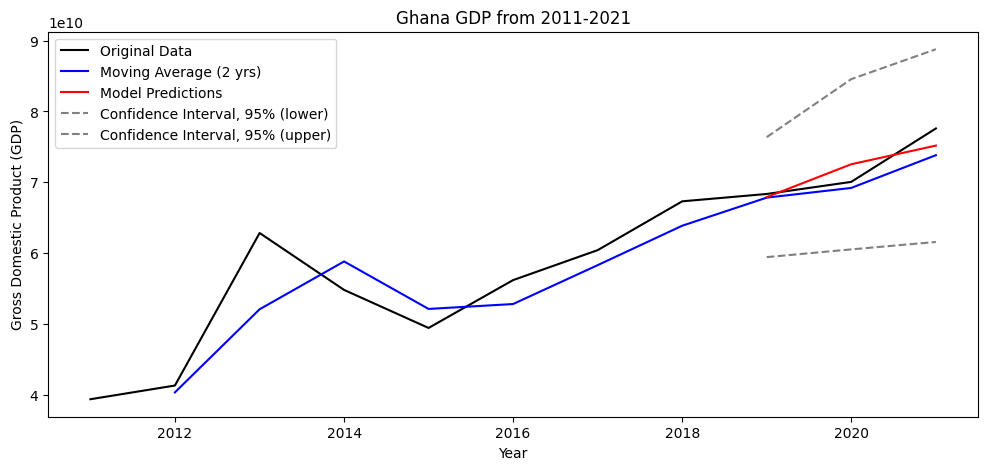

In [18]:
#extract data from the past 10 years
ten_years = ghana_data.iloc[-11:]
q = 2
rolling_mean = ten_years[ghana_data.columns[0]].rolling(window=q).mean()


plt.rcParams['figure.figsize'] = 12, 5

fig, ax = plt.subplots()

#original data
plt.plot(ten_years[ghana_data.columns[0]],
         label='Original Data',
         color='black')

plt.plot(rolling_mean,
         label=f'Moving Average ({q} yrs)',
         color='blue')

#predictions
plt.plot(
    pred_df.loc[test_df.index]['model_prediction'],
    color='red',
    linestyle='-',
    label='Model Predictions'
)

#confidence interval(s)
plt.plot(
    pred_df.loc[test_df.index]['model_prediction_lower'],
    color='grey',
    linestyle='--',
    label='Confidence Interval, 95% (lower)'
)

plt.plot(
    pred_df.loc[test_df.index]['model_prediction_upper'],
    color='grey',
    linestyle='--',
    label='Confidence Interval, 95% (upper)'
)


plt.title('Ghana GDP from 2011-2021')
plt.xlabel('Year')
plt.ylabel('Gross Domestic Product (GDP)')
plt.legend()

plt.show()

Модель ARIMA(1, 2, 3) довольно близко предсказала значения GDP за последние три года.

#### **PART 1.6**

Сделайте выводы по полученным результатам.

Ключевые метрики для оценки моделей прогнозирования временных рядов включают среднюю абсолютную ошибку (MAE), среднеквадратичную ошибку (RMSE), среднюю абсолютную процентную ошибку (MAPE), R-квадрат (R²) и смещение прогноза. \
Эти метрики помогают оценить точность модели, надежность и тенденцию к перепрогнозированию или недопрогнозированию.

In [19]:
actual, predicted = list(test_df.values), list(pred_df.iloc[-3:, 0].values)

mape = metrics.mean_absolute_percentage_error(actual, predicted) * 100
r2 = metrics.r2_score(actual, predicted)

mae = metrics.mean_absolute_error(actual, predicted)
rmse = metrics.root_mean_squared_error(actual, predicted)

print(f'Mean Absolute Percentage Error: {mape:.2f}')
print(f'R2: {r2:.5f}')
print(f'Mean Absolute Error: {mae: 2e}')
print(f'Root Mean Squared Error: {rmse: 2e}')

Mean Absolute Percentage Error: 2.44
R2: 0.74741
Mean Absolute Error:  1.785866e+09
Root Mean Squared Error:  2.021571e+09


Значение MAPE ниже 10% считается очень хорошим, кроме того, R2 близко к 1, и на уровне 0,75 показывает, что модель объясняет довольно большую часть вариации данных.
Доверительные интервалы показывают, что реальные данные попали в их диапазон.

Однако, хотя модель и показывает неплохие прогнозы, это касается только последних 3 лет, и модель может не показывать хороших результатов на реальных данных.

### **PART TWO**

Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода DataFrame.asfreq(), передав в него параметр частоты, например ‘d’ — день, ‘m’ — месяц. Все алиасы для параметров частоты доступны по ссылке.

Подсказка
df.asfreq(freq='AS')

In [20]:
new_ghana_data = ghana_data.asfreq(freq='YS')
new_ghana_data

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


Проверьте данные на наличие пропущенных значений (Series.isna().sum()).

In [21]:
new_ghana_data.isna().sum()

GDP (current US$)    0
dtype: int64

Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN. Воспользуйтесь кодом ниже:

import numpy as np
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

In [22]:
new_ghana_data[new_ghana_data[new_ghana_data.columns[0]] == 0]

,GDP (current US$)
year,
1961-01-01,0.0


In [23]:
new_ghana_data[new_ghana_data.columns[0]] = new_ghana_data[new_ghana_data.columns[0]].apply(lambda x: np.nan if x==0 else x)

new_ghana_data[new_ghana_data[new_ghana_data.columns[0]].isna()==True]

,GDP (current US$)
year,
1961-01-01,NaN


Для заполнения пропусков выполните интерполяцию с использованием метода .interpolate().

Подсказка
df['GDP (current US$)'].interpolate(method='linear')

In [24]:
new_ghana_data[new_ghana_data.columns[0]].interpolate(method='linear',
                                                      inplace=True)

new_ghana_data.isna().sum()

GDP (current US$)    0
dtype: int64

In [25]:
train_df, test_df = new_ghana_data[:-3], new_ghana_data[-3:]

print(f'Размерность тренировочной выборки: {train_df.shape}')
print(f'Размерность тестовой выборки: {test_df.shape}')

Размерность тренировочной выборки: (59, 1)
Размерность тестовой выборки: (3, 1)


Проверьте полученный ряд на стационарность, определите параметры модели (ARIMA/ARMA) и запустите модель.

In [26]:
print(execute_augmented_dickey_fuller_test(train_df, 1))
print(execute_augmented_dickey_fuller_test(train_df, 5))
print(execute_augmented_dickey_fuller_test(train_df, 10))

ADF: 0.80301
p_value: 0.99168
critical value, 1%: -3.57459
at 1% threshold: 0.80301 > -3.57459 thus series is not stationary as roots exist
ADF: 0.80301
p_value: 0.99168
critical value, 5%: -2.92395
at 5% threshold: 0.80301 > -2.92395 thus series is not stationary as roots exist
ADF: 0.80301
p_value: 0.99168
critical value, 10%: -2.60004
at 10% threshold: 0.80301 > -2.60004 thus series is not stationary as roots exist


In [27]:
print(execute_augmented_dickey_fuller_test(train_df.diff().dropna(), 1))
print(execute_augmented_dickey_fuller_test(train_df.diff().dropna(), 5))
print(execute_augmented_dickey_fuller_test(train_df.diff().dropna(), 10))

ADF: -1.82557
p_value: 0.36785
critical value, 1%: -3.56849
at 1% threshold: -1.82557 > -3.56849 thus series is not stationary as roots exist
ADF: -1.82557
p_value: 0.36785
critical value, 5%: -2.92136
at 5% threshold: -1.82557 > -2.92136 thus series is not stationary as roots exist
ADF: -1.82557
p_value: 0.36785
critical value, 10%: -2.59866
at 10% threshold: -1.82557 > -2.59866 thus series is not stationary as roots exist


In [28]:
print(execute_augmented_dickey_fuller_test(train_df.diff(2).dropna(), 1))
print(execute_augmented_dickey_fuller_test(train_df.diff(2).dropna(), 5))
print(execute_augmented_dickey_fuller_test(train_df.diff(2).dropna(), 10))

ADF: -3.9998
p_value: 0.00141
critical value, 1%: -3.58483
at 1% threshold - series is stationary as roots do not exist
ADF: -3.9998
p_value: 0.00141
critical value, 5%: -2.9283
at 5% threshold - series is stationary as roots do not exist
ADF: -3.9998
p_value: 0.00141
critical value, 10%: -2.60234
at 10% threshold - series is stationary as roots do not exist


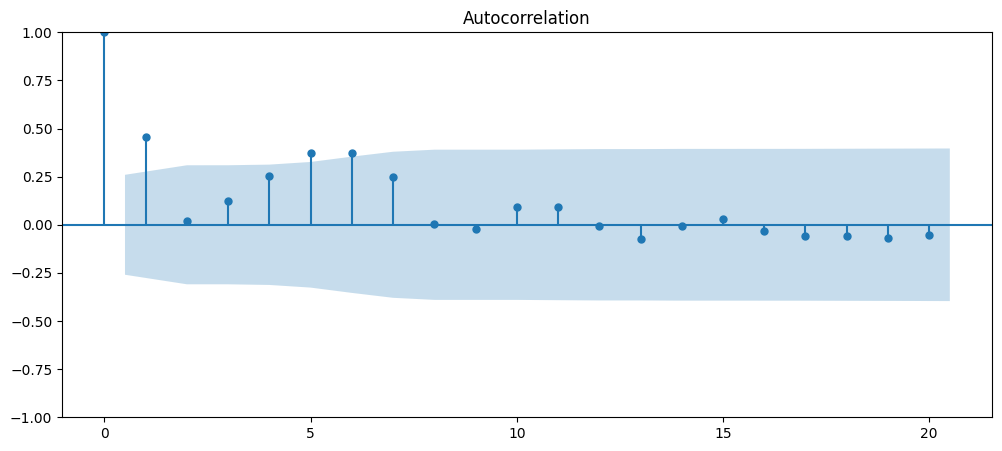

In [29]:
tsaplots.plot_acf(train_df.diff(2).dropna(),
                  lags=20);

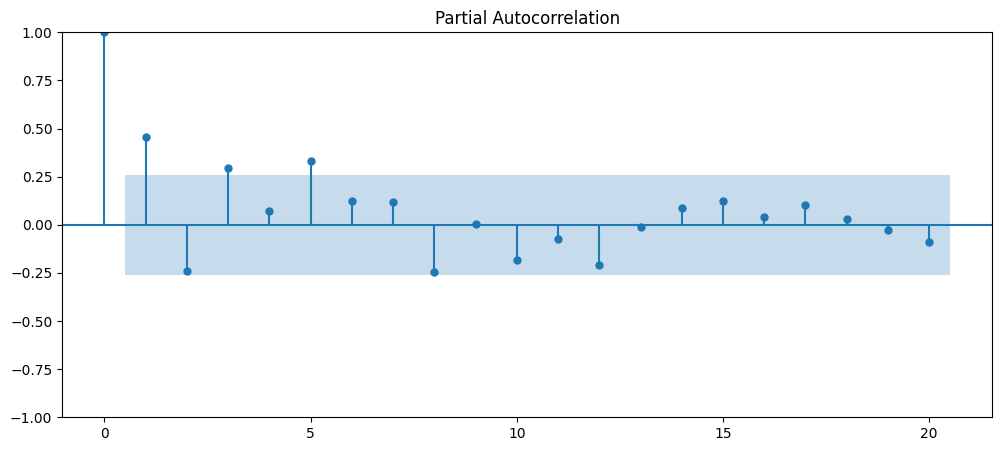

In [30]:
tsaplots.plot_pacf(train_df.diff(2).dropna(),
                   lags=20)
plt.show()

In [31]:
upgraded_arima_model = model.ARIMA(train_df,
                                   order=(1, 2, 1));

fit_upgraded_arima_model = upgraded_arima_model.fit()

fit_upgraded_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.188
Date:                Tue, 10 Jun 2025   AIC                           2684.377
Time:                        06:11:12   BIC                           2690.506
Sample:                    01-01-1960   HQIC                          2686.759
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1750      0.082     -2.127      0.033      -0.336      -0.014
ma.L1         -0.8690      0.046    -19.050      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22   9.21e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               277.83
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             480.68   Skew:                             1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.9e+57. Standard errors may be unstable.
"""

AIC незначительно улучшилась (**2684.377** < 2684.416), но сказывается корректировка ряда с 0 по NaN значением.

In [32]:
#search for better hyperparameters
upgraded_auto_arima_model = pm.arima.auto_arima(
    train_df,
    start_p=1,
    d=2,
    start_q=1,
    test='adf',
    max_p=10,
    max_d=10,
    max_q=10,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

upgraded_auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.479, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.621, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.528, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.00 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.221, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.822, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.929, Time=0.03 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.861, Time=0.01 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.709, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2692.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Tue, 10 Jun 2025   AIC                           2680.513
Time:                        06:11:13   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.19e+55. Standard errors may be unstable.
"""

AIC немного улучшилась (**2680.513** < 2680.765). \
Выбранные параметры (1, 2, 3).

In [33]:
optimal_arima_model = model.ARIMA(train_df,
                                  order=upgraded_auto_arima_model.get_params()['order']
)

fit_optimal_arima_model = optimal_arima_model.fit()

fit_optimal_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Tue, 10 Jun 2025   AIC                           2680.513
Time:                        06:11:13   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.19e+55. Standard errors may be unstable.
"""

Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

In [34]:
test_pred = fit_optimal_arima_model.predict(start=test_df.index[0],
                                            end=test_df.index[-1],
                                            dynamic=False)

test_pred

2019-01-01    6.781358e+10
2020-01-01    7.249485e+10
2021-01-01    7.509393e+10
Freq: YS-JAN, Name: predicted_mean, dtype: float64

In [35]:
pred_df2 = pd.DataFrame(index=ghana_data.index)

pred_df2['model_prediction'] = fit_optimal_arima_model.predict(start=test_df.index[0],
                                                               end=test_df.index[-1])

test_forecast2 = fit_optimal_arima_model.get_forecast(len(test_df.index))

#confidence level
forecast_df2 = test_forecast2.conf_int(alpha=0.05)

pred_df2.at[test_df.index, 'model_prediction_lower'] = forecast_df2['lower GDP (current US$)']
pred_df2.at[test_df.index, 'model_prediction_upper'] = forecast_df2['upper GDP (current US$)']

pred_df2.tail(3)

,model_prediction,model_prediction_lower,model_prediction_upper
year,,,
2019-01-01,6.781358e+10,5.934528e+10,7.628189e+10
2020-01-01,7.249485e+10,6.044242e+10,8.454729e+10
2021-01-01,7.509393e+10,6.145217e+10,8.873569e+10


In [36]:
actual, predicted = list(test_df.values), list(pred_df2.iloc[-3:, 0].values)

mape = metrics.mean_absolute_percentage_error(actual, predicted) * 100
r2 = metrics.r2_score(actual, predicted)

mae = metrics.mean_absolute_error(actual, predicted)
rmse = metrics.root_mean_squared_error(actual, predicted)

print(f'Mean Absolute Percentage Error: {mape:.2f}')
print(f'R2: {r2:.5f}')
print(f'Mean Absolute Error: {mae: 2e}')
print(f'Root Mean Squared Error: {rmse: 2e}')

Mean Absolute Percentage Error: 2.50
R2: 0.74171
Mean Absolute Error:  1.825318e+09
Root Mean Squared Error:  2.044250e+09


Метрики показывают немного худший результат по сравнение с исходной моделью, но небольшое падение из-за изменения одного значения с 0 на NaN. \
Однако AIC показывает немного лучший результат, поэтому возможно, что текущая модель является улучшением по сравнению с предыдущей, но, опять же, трудно быть уверенным, не проведя дополнительных тестов.

### **PART THREE**

#### **PART 3.1**

Посчитайте волатильность для вашего временного ряда.

В контексте анализа временных рядов волатильность относится к степени вариации или колебания значений временного ряда с течением времени. По сути, она описывает, насколько сильно меняется ряд, указывая на его уровень непредсказуемости или риска.

In [37]:
ghana_volatility = pd.DataFrame(new_ghana_data[new_ghana_data.columns[0]].pct_change(1).mul(100).abs())

ghana_volatility = ghana_volatility.dropna()

ghana_volatility = ghana_volatility.rename(columns={
    'GDP (current US$)': 'Volatility'
})

ghana_volatility.head()

,Volatility
year,
1961-01-01,6.789413
1962-01-01,6.357759
1963-01-01,11.448835
1964-01-01,12.363636
1965-01-01,18.608414


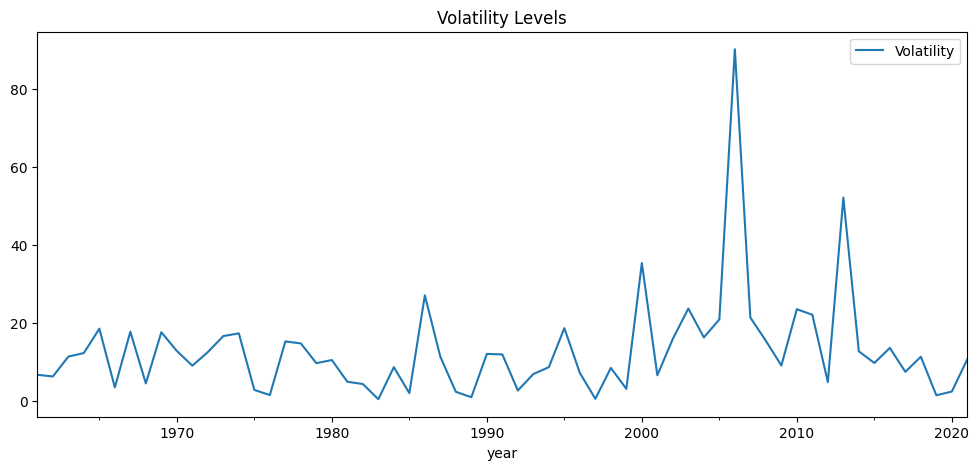

In [38]:
ghana_volatility.plot(figsize=(12, 5))

plt.title('Volatility Levels')
plt.show()

In [39]:
#find the peak values
top_volatility_levels = ghana_volatility.nlargest(4, 'Volatility')
top_volatility_levels

,Volatility
year,
2006-01-01,90.242074
2013-01-01,52.220960
2000-01-01,35.447657
1986-01-01,27.157362


Довольно стабильная волатильность на протяжении всего периода, за исключением нескольких периодов в 1986 - 27%, 2000 - 35%, 2006 - 90%, и 2013 - 52%.

Потенциально может быть объяснено рядом факторов:
- 1986 - переход от системы фиксированного обменного курса к более рыночному подходу в Гане;
- 2000 - передача власти в Гане, в Америке пузырь dotcom, в результате чего многочисленные start-ups потерпели неудачу после истощения своего венчурного капитала, не став прибыльными;
- 2006 - рыночная капитализация страны выросла, а фондовая биржа Ганы отметила рост активности;
- 2013 - экономика столкнулась с трудностями, включая инфляцию, давление обменного курса и энергетические кризисы.

Скачков не очень много, поэтому можно предположить, что ряд достаточно гомоскедастичен.

#### **PART 3.2**

Используйте GARCH-модель для предсказания волатильности.

In [40]:
new_train_df, new_test_df = ghana_volatility[:-3], ghana_volatility[-3:]

print(f'Размерность тренировочной выборки: {new_train_df.shape}')
print(f'Размерность тестовой выборки: {new_test_df.shape}')

Размерность тренировочной выборки: (58, 1)
Размерность тестовой выборки: (3, 1)


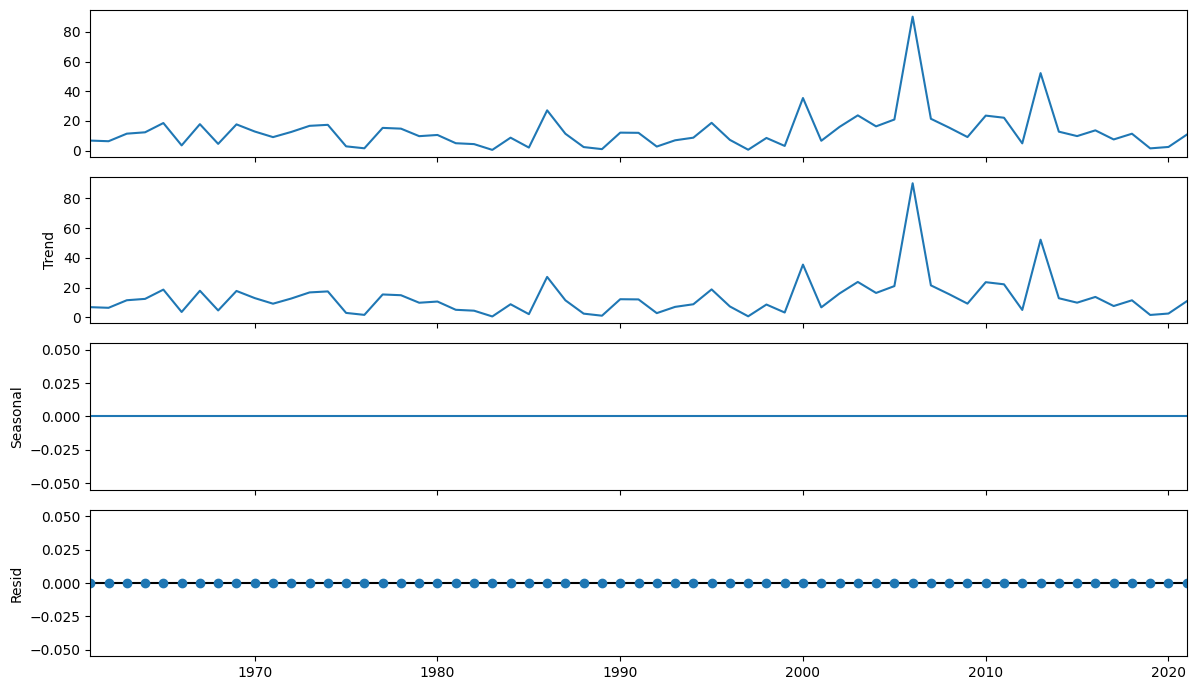

In [41]:
plt.rcParams['figure.figsize'] = 12, 7

decomposition = seasonal.seasonal_decompose(ghana_volatility)
decomposition.plot();

In [42]:
print(execute_augmented_dickey_fuller_test(new_train_df, 1))
print(execute_augmented_dickey_fuller_test(new_train_df, 5))
print(execute_augmented_dickey_fuller_test(new_train_df, 10))

ADF: -6.72531
p_value: 0.0
critical value, 1%: -3.55067
at 1% threshold - series is stationary as roots do not exist
ADF: -6.72531
p_value: 0.0
critical value, 5%: -2.91377
at 5% threshold - series is stationary as roots do not exist
ADF: -6.72531
p_value: 0.0
critical value, 10%: -2.59462
at 10% threshold - series is stationary as roots do not exist


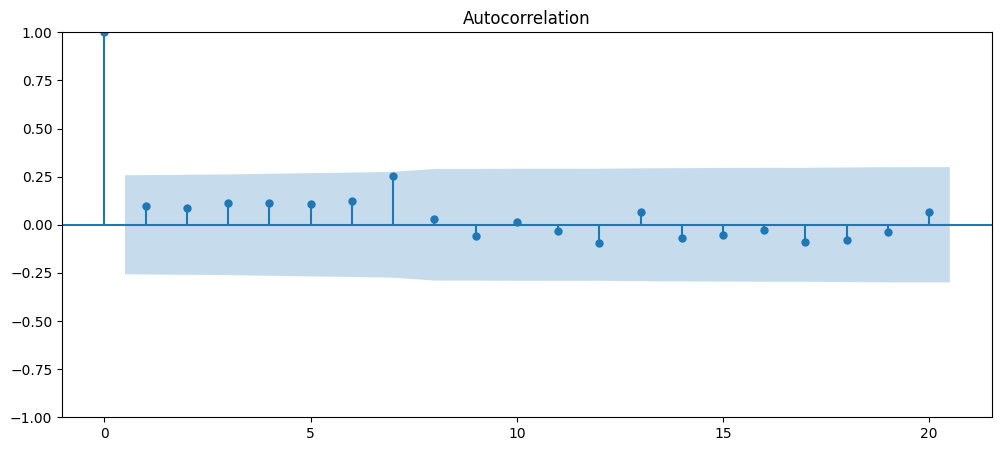

In [43]:
plt.rcParams['figure.figsize'] = 12, 5

tsaplots.plot_acf(new_train_df,
                  lags=20);

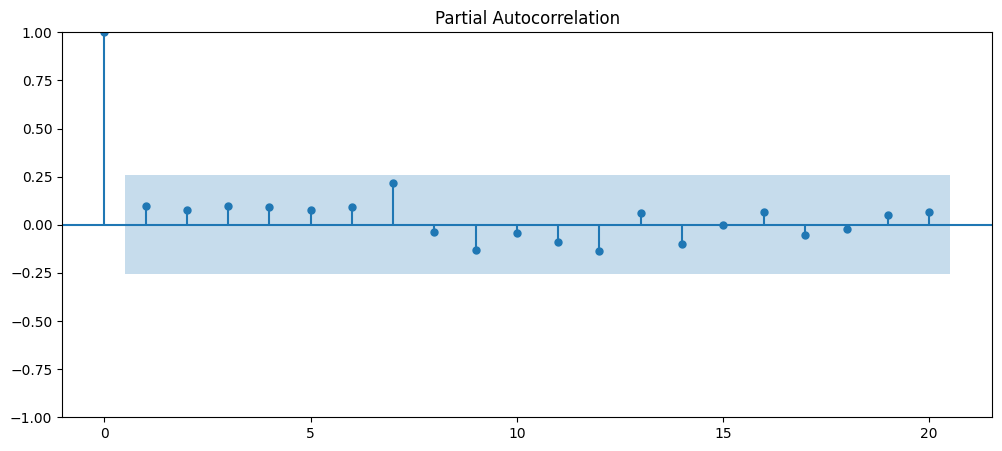

In [44]:
plt.rcParams['figure.figsize'] = 12, 5

tsaplots.plot_pacf(new_train_df,
                   lags=20)
plt.show()

В общем случае не следует превышать порядок GARCH **p = q = 2**, поскольку это очень часто приводит к переобучению и редко дает хорошие результаты вне выборки. \
Останавливаемся на модели (1, 1).

In [45]:
garch_model = univariate.arch_model(ghana_volatility,
                                    p=1,
                                    q=1,
                                    vol='GARCH')

fit_garch_model = garch_model.fit(last_obs=test_df.index[0],
                                  update_freq=5)

fit_garch_model

Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.1880097581334
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4853.658048835593
Iteration:     15,   Func. Count:     89,   Neg. LLF: 228.00192080319667
Iteration:     20,   Func. Count:    114,   Neg. LLF: 226.59783329731593
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.59781233102035
            Iterations: 22
            Function evaluations: 123
            Gradient evaluations: 22


                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                Tue, Jun 10 2025   Df Residuals:                       57
Time:                        06:11:14   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3191      2.572      4.791  1.663e-06 [  7.279, 17.35

In [46]:
pred_garch = test_df.copy()

pred_garch['pred_garch'] = fit_garch_model.forecast().residual_variance.loc[test_df.index]

pred_garch

,GDP (current US$),pred_garch
year,,
2019-01-01,6.833754e+10,288.544116
2020-01-01,7.004320e+10,292.214106
2021-01-01,7.759428e+10,295.884097


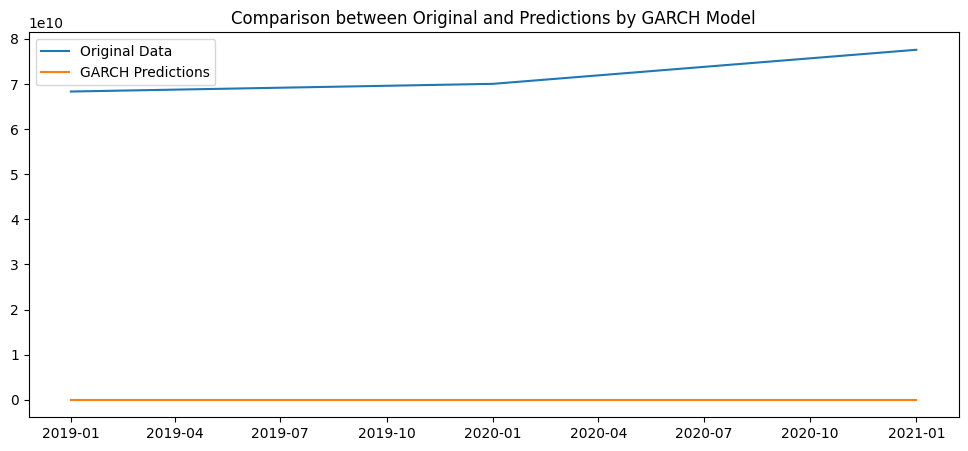

In [47]:
plt.figure(figsize=(12, 5))

plt.plot(pred_garch[pred_garch.columns[0]],
         label='Original Data')

plt.plot(pred_garch[pred_garch.columns[1]],
         label='GARCH Predictions')

plt.legend()
plt.title('Comparison between Original and Predictions by GARCH Model');

#### **PART 3.3**

Используйте линейную регрессию для получения прогноза.

In [48]:
X_train = pd.DataFrame(range(ghana_volatility['Volatility'].shape[0]))[:new_train_df.shape[0]]
X_test = pd.DataFrame(range(ghana_volatility['Volatility'].shape[0]))[new_train_df.shape[0]:]
y_train = new_train_df['Volatility']
y_test = new_test_df['Volatility']

linear_model = linear_model.LinearRegression()

linear_model.fit(X_train, y_train)

pred_lm = linear_model.predict(X_test)
pred_lm

array([19.81968247, 20.03529022, 20.25089797])

#### **PART 3.4**

Визуализируйте полученное предсказание вместе с фактическим значением.

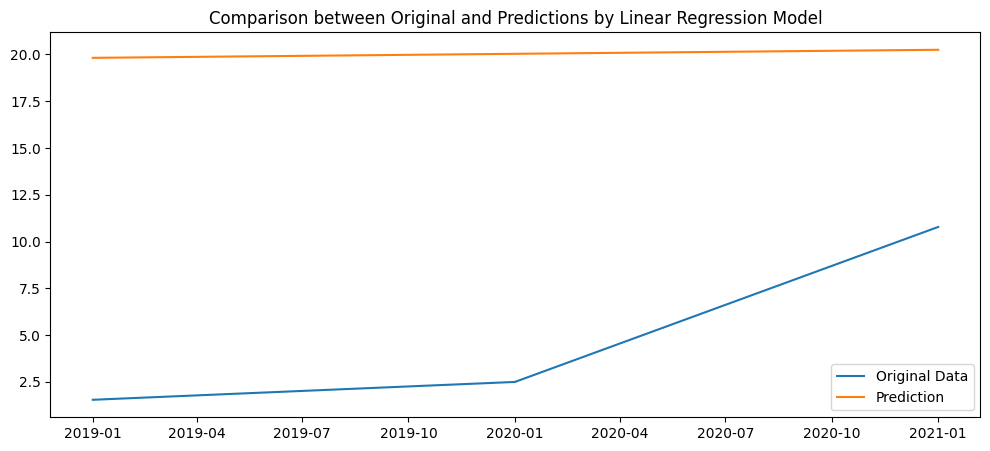

In [49]:
plt.figure(figsize=(12, 5))

plt.plot(y_test,
         label='Original Data')

plt.plot(pd.Series(pred_lm,
                   index=y_test.index),
         label='Prediction')

plt.title(f'Comparison between Original and Predictions by Linear Regression Model')
plt.legend();

#### **PART 3.5**

Сравните результаты и сделайте выводы.

GARCH MODEL METRICS

In [50]:
actual_g, predicted_g = list(ghana_volatility.iloc[-3:, 0].values), list(pred_garch.iloc[:, 1].values)

mape = metrics.mean_absolute_percentage_error(actual_g, predicted_g) * 100
r2 = metrics.r2_score(actual_g, predicted_g)

mae = metrics.mean_absolute_error(actual_g, predicted_g)
rmse = metrics.root_mean_squared_error(actual_g, predicted_g)

print(f'Mean Absolute Percentage Error: {mape:.2f}')
print(f'R2: {r2:.5f}')
print(f'Mean Absolute Error: {mae: 2e}')
print(f'Root Mean Squared Error: {rmse: 2e}')

Mean Absolute Percentage Error: 10951.82
R2: -4794.71541
Mean Absolute Error:  2.872743e+02
Root Mean Squared Error:  2.872806e+02


LINEAR REGRESSION METRICS

In [51]:
actual_lm, predicted_lm = list(ghana_volatility.iloc[-3:, 0].values), list(pred_lm)

mape = metrics.mean_absolute_percentage_error(actual_lm, predicted_lm) * 100
r2 = metrics.r2_score(actual_lm, predicted_lm)

mae = metrics.mean_absolute_error(actual_lm, predicted_lm)
rmse = metrics.root_mean_squared_error(actual_lm, predicted_lm)

print(f'Mean Absolute Percentage Error: {mape:.2f}')
print(f'R2: {r2:.2f}')
print(f'Mean Absolute Error: {mae: 2e}')
print(f'Root Mean Squared Error: {rmse: 2e}')

Mean Absolute Percentage Error: 658.42
R2: -13.17
Mean Absolute Error:  1.509553e+01
Root Mean Squared Error:  1.561369e+01


Ни Garch, ни стандартная линейная регрессия не могут правильно предсказать данные, как показывают плохие показатели:
- MAPE в 100% указывает на совершенно неточный прогноз, то есть прогнозируемое значение равно нулю, когда фактическое значение не равно нулю;
- R2 будет отрицательным, если линия или кривая плохо соответствует данным;
- MAE и RMSE лучше при использовании модели линейной регрессии.

#### **PART 3.6**

Почему результат модели GARCH получился именно таким?

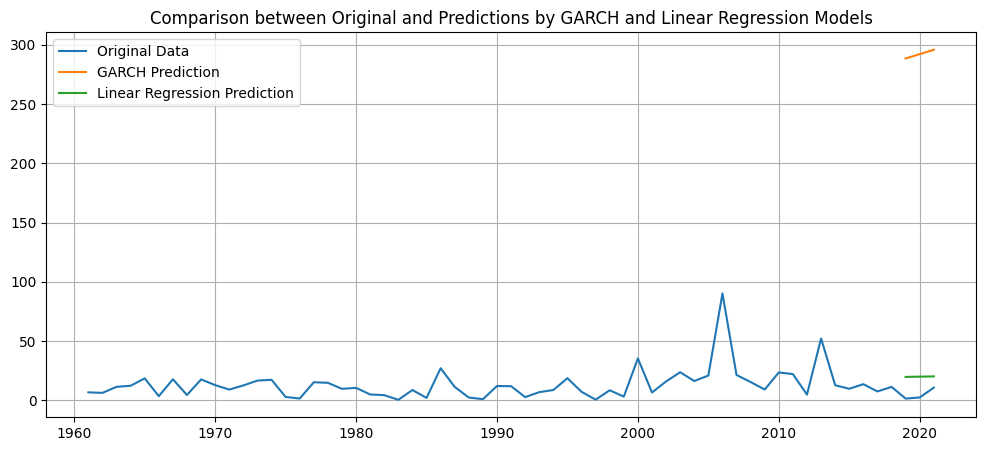

In [52]:
plt.figure(figsize=(12, 5))
plt.plot(ghana_volatility,
         label='Original Data')

plt.plot(pred_garch[pred_garch.columns[1]],
         label='GARCH Prediction')

plt.plot(pd.Series(pred_lm,
                   index=y_test.index),
         label='Linear Regression Prediction')

plt.title('Comparison between Original and Predictions by GARCH and Linear Regression Models')
plt.legend()
plt.grid();

Модели не смогли уловить дисперсию:
- Линейная регрессия плохо работает с данными временных рядов, поскольку она нарушает предположение о независимых наблюдениях, что имеет решающее значение для точного построения модели и вывода. Данные временных рядов демонстрируют закономерности и зависимости с течением времени, что означает, что значения коррелируют с их прошлыми значениями (автокорреляция). Линейная регрессия, разработанная для независимых данных, с трудом улавливает эти временные связи и может привести к смещенным оценкам дисперсии и ненадежным прогнозам.
- Модели GARCH в основном используются для анализа и прогнозирования волатильности временных рядов данных, а текущие данные не достаточно волатильны, в данных присутствует гомоскедастичность, и скорее всего данные не станут волатильными в будущем.